### Necessary Imports and Settings
    for any step in the following notebook

In [1]:
import os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import cmb_anomaly_utils as cau

In [2]:
plt.rcParams['text.usetex'] = True
plt.rc('font', family='serif')
plt.rc('legend', facecolor='white', edgecolor='k', framealpha=1)
plt.rcParams['xtick.major.size'] = 3.5
plt.rcParams['ytick.major.size'] = 3.5
plt.rcParams['xtick.labelsize']  = 12
plt.rcParams['ytick.labelsize']  = 12

In [3]:
base_path                       = "./output/noisy_masked_measure/"
cleaning_pipeline               = "commander"
run_inputs  = cau.run_utils.RunInputs()
run_inputs.max_sim_num          = 1000
run_inputs.mask_fpath           = "./input/cmb_fits_files/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits"
run_inputs.cmb_fpath            = "./input/cmb_fits_files/COM_CMB_IQU-{}_2048_R3.00_full.fits".format(cleaning_pipeline)
run_inputs.sims_path            = "./input/{}_sims/".format(cleaning_pipeline)
run_inputs.noise_path           = "./input/{}_noise/".format(cleaning_pipeline)
run_inputs.geom_flag            = cau.const.CAP_FLAG
run_inputs.measure_flag         = cau.const.VAR_FLAG
run_inputs.is_masked            = True
run_inputs.min_pix_ratio        = 0.1
run_inputs.nside                = 64
run_inputs.dir_nside            = 16
run_inputs.geom_start           = 0
run_inputs.geom_stop            = 180
run_inputs.delta_geom_samples   = 1
run_inputs.stripe_thickness     = 20
run_inputs.lmax                 = 30

dir_search_cap_sizes = cau.stat_utils.get_range(5, 90, 5)
max_sim_num = run_inputs.max_sim_num

### Pepare Temperature Maps

In [9]:
print("Warming Up!")

map_gen = cau.run_utils.MapGenerator(**run_inputs.to_kwargs())

dummy_map = map_gen.create_dummy_map()
dir_lat, dir_lon = cau.coords.get_healpix_latlon(run_inputs.dir_nside)
ndir = cau.coords.get_npix(run_inputs.dir_nside)
measure_dir_indices = np.arange(ndir, dtype=int)

cmb_measure = np.zeros(ndir)
sims_measure = np.zeros((max_sim_num, ndir))

print("Reading CMB Data:")
cmb_map = map_gen.create_cmb_map()
cau.map_utils.remove_monopole_dipole(cmb_map)
print("\t-Done-")

print("Providing Simulations:")
sims_maps: list[cau.dtypes.PixMap] = []
for sim_num in range(max_sim_num):
    print("\t{:04}/{:04}\r".format(sim_num + 1, max_sim_num), end="")
    sim_pix_map = map_gen.create_sim_map_from_txt(sim_num, use_noise=False)
    cau.map_utils.remove_monopole_dipole(sim_pix_map)
    sims_maps.append(sim_pix_map)
print("")

Warming Up!
Reading CMB Data:
	-Done-
Providing Simulations:
	1000/1000


### Calculate Cap (RAW)Variances
    "Pepare Temperature Maps" Section is needed in memory

In [5]:
for cap_size in dir_search_cap_sizes:
    print("Disc Size(deg): {:2}".format(cap_size))
    print("Calculating Cap Measures:")
    for dir_i in measure_dir_indices:
        print(f"\t{dir_i}/{ndir - 1}\r", end="")
        # Separating Common Geometry -> Top cap & Bottom cap
        plat, plon = dir_lat[dir_i], dir_lon[dir_i]
        dummy_map.change_pole(plat, plon)
        top_filter, bottom_filter = cau.geometry.get_top_bottom_caps_selection_filters( pix_map = dummy_map,
                                                                                        cap_angle = cap_size)
        top_cap, bottom_cap = cau.geometry.get_top_bottom_caps_by_filters( pix_map = cmb_map,
                                                                           top_sel = top_filter,
                                                                           bottom_sel = bottom_filter)
        visible_ratio = top_cap.get_visible_pixels_ratio()
        # CMB measure
        cmb_measure[dir_i] = \
            np.nan if visible_ratio < run_inputs.min_pix_ratio else \
                cau.measure.calc_var(top_cap, bottom_cap, **run_inputs.to_kwargs())
        # Simulation Measure
        for sim_num in range(max_sim_num):
            top_cap, bottom_cap = cau.geometry.get_top_bottom_caps_by_filters( pix_map = sims_maps[sim_num],
                                                                               top_sel = top_filter,
                                                                               bottom_sel = bottom_filter)
            sims_measure[sim_num, dir_i] = \
                np.nan if visible_ratio < run_inputs.min_pix_ratio else \
                    cau.measure.calc_var(top_cap, bottom_cap, **run_inputs.to_kwargs())
    print("")

    np.savetxt(base_path + "{}_cmb_var_{:02}cap.txt".format(cleaning_pipeline, cap_size), cmb_measure)
    np.savetxt(base_path + "{}_sims_var_{:02}cap.txt".format(cleaning_pipeline, cap_size), sims_measure)

# print("-Done-")

Disc Size(deg): 5.0
Calculating Cap Measures:
	3071/3071
Disc Size(deg): 10.0
Calculating Cap Measures:
	3071/3071
Disc Size(deg): 15.0
Calculating Cap Measures:
	3071/3071
Disc Size(deg): 20.0
Calculating Cap Measures:
	3071/3071
Disc Size(deg): 25.0
Calculating Cap Measures:
	3071/3071
Disc Size(deg): 30.0
Calculating Cap Measures:
	3071/3071
Disc Size(deg): 35.0
Calculating Cap Measures:
	3071/3071
Disc Size(deg): 40.0
Calculating Cap Measures:
	3071/3071
Disc Size(deg): 45.0
Calculating Cap Measures:
	3071/3071
Disc Size(deg): 50.0
Calculating Cap Measures:
	3071/3071
Disc Size(deg): 55.0
Calculating Cap Measures:
	3071/3071
Disc Size(deg): 60.0
Calculating Cap Measures:
	3071/3071
Disc Size(deg): 65.0
Calculating Cap Measures:
	3071/3071
Disc Size(deg): 70.0
Calculating Cap Measures:
	3071/3071
Disc Size(deg): 75.0
Calculating Cap Measures:
	3071/3071
Disc Size(deg): 80.0
Calculating Cap Measures:
	3071/3071
Disc Size(deg): 85.0
Calculating Cap Measures:
	3071/3071
Disc Size(deg):

### Finding Dipole Direction on Cap-Var Maps Considering $Mean(Var) \; \& \; Var(Var)$
    "Calculate Cap (RAW)Variances" Section has to be computed and stored

In [4]:
n_cap_sizes = len(dir_search_cap_sizes)

# The number of the direction's pixel will be stored
cmb_directions = np.zeros((n_cap_sizes))
sims_directions = np.zeros((n_cap_sizes, max_sim_num))

dummy_map = cau.dtypes.PixMap.create_dummy(run_inputs.dir_nside)

for cs_i, cap_size in enumerate(dir_search_cap_sizes):
    cmb_var  = np.loadtxt(base_path + "{}_cmb_var_{:02}cap.txt".format(cleaning_pipeline, cap_size))
    sims_var = np.loadtxt(base_path + "{}_sims_var_{:02}cap.txt".format(cleaning_pipeline, cap_size))

    #----COMMON ASSETS----
    # Common Mean and Var of Simulated Maps
    _mean = np.mean(sims_var, axis = 0)
    _var  = np.var(sims_var, axis = 0)
    # Common Mask
    _mask = np.isnan(cmb_var)
    dummy_map.mask = _mask if np.any(_mask) else None
    
    #----SPECIFIC CALCULATIONS----
    # CMB Direction
    dummy_map.data = (cmb_var - _mean) / _var
    cmb_directions[cs_i] = cau.map_utils.get_dipole_direction_index(pix_map = dummy_map,
                                                                    dir_nside = run_inputs.dir_nside)
    # Simulations Directions
    for sim_num in range(max_sim_num):
        dummy_map.data = (sims_var[sim_num] - _mean) / _var
        sims_directions[cs_i, sim_num] = \
            cau.map_utils.get_dipole_direction_index(pix_map = dummy_map,
                                                     dir_nside = run_inputs.dir_nside)

np.savetxt(base_path + "{}_cmb_var_dir.txt".format(cleaning_pipeline), cmb_directions, fmt = '%i')
np.savetxt(base_path + "{}_sims_var_dir.txt".format(cleaning_pipeline), sims_directions, fmt = '%i')

### ***(Depricated Section)*** Taking Stripes and Calculating $Var(T)$ Considering $Mean(Var) \; \& \; Var(Var)$
    "Pepare Temperature Maps" Section is needed in memory

In this section, to compute measures for each map we should:

1. take the direction of the target map (it can be CMB or any simulated map) and align all simulated maps to the direction of the target map
2. compute measure for stripes in target map and all simulated maps
3. subtract the mean of stripes of simulated maps from target map and divide it by the variance of the measure 

In [10]:
cmb_directions  = np.loadtxt(base_path + "{}_cmb_var_dir.txt".format(cleaning_pipeline), dtype=int)
sims_directions = np.loadtxt(base_path + "{}_sims_var_dir.txt".format(cleaning_pipeline), dtype=int)

dir_lat, dir_lon = cau.coords.get_healpix_latlon(run_inputs.dir_nside)

n_cap_sizes = len(dir_search_cap_sizes)

cmb_stripe_measure   = np.zeros(len(run_inputs.geom_range))
sims_stripe_measures = np.zeros((max_sim_num, len(run_inputs.geom_range)))

print("Computing stripe measures (subtracting stripes' mean fields)")
for cs_i, cap_size in enumerate(dir_search_cap_sizes):
    print("Disc Size(deg): {:2}".format(cap_size))
    #----CMB Measure----
    print("Computing CMB")
    dir_index = cmb_directions[cs_i]
    plat, plon = dir_lat[dir_index], dir_lon[dir_index]
    cmb_map.change_pole(plat, plon)
    cmb_stripe_measure = \
        cau.measure.calc_stripe_measure_subtract_mean_field(
            cmb_map,
            sims_maps,
            **run_inputs.to_kwargs())
    print("\t-Done-")

    #----Simulation Measure----
    print("Computing Simulations")
    for sim_num in range(max_sim_num):
        print("\t{:04}/{:04}\r".format(sim_num + 1, max_sim_num), end="")
        dir_index = sims_directions[cs_i, sim_num]
        plat, plon = dir_lat[dir_index], dir_lon[dir_index]
        sims_maps[sim_num].change_pole(plat, plon)
        sims_stripe_measures[sim_num] = \
            cau.measure.calc_stripe_measure_subtract_mean_field(
                sims_maps[sim_num],
                sims_maps,
                **run_inputs.to_kwargs())
    print("\t-Done-")
    
    np.savetxt(base_path + "{}_cmb_{:02}stripe_var_measure_{:02}deg_dir.txt".format(cleaning_pipeline, run_inputs.stripe_thickness, cap_size), cmb_stripe_measure)
    np.savetxt(base_path + "{}_sims_{:02}stripe_var_measure_{:02}deg_dir.txt".format(cleaning_pipeline, run_inputs.stripe_thickness, cap_size), sims_stripe_measures)

Computing stripe measures (subtracting stripes' mean fields)
Disc Size(deg): 5.0
Computing CMB
	-Done-
Computing Simulations
	-Done-000
Disc Size(deg): 10.0
Computing CMB
	-Done-
Computing Simulations
	-Done-000
Disc Size(deg): 15.0
Computing CMB
	-Done-
Computing Simulations
	-Done-000
Disc Size(deg): 20.0
Computing CMB
	-Done-
Computing Simulations
	-Done-000
Disc Size(deg): 25.0
Computing CMB
	-Done-
Computing Simulations
	-Done-000
Disc Size(deg): 30.0
Computing CMB
	-Done-
Computing Simulations
	-Done-000
Disc Size(deg): 35.0
Computing CMB
	-Done-
Computing Simulations
	-Done-000
Disc Size(deg): 40.0
Computing CMB
	-Done-
Computing Simulations
	-Done-000
Disc Size(deg): 45.0
Computing CMB
	-Done-
Computing Simulations
	-Done-000
Disc Size(deg): 50.0
Computing CMB
	-Done-
Computing Simulations
	-Done-000
Disc Size(deg): 55.0
Computing CMB
	-Done-
Computing Simulations
	-Done-000
Disc Size(deg): 60.0
Computing CMB
	-Done-
Computing Simulations
	-Done-000
Disc Size(deg): 65.0
Computi

#### Plotting Measures

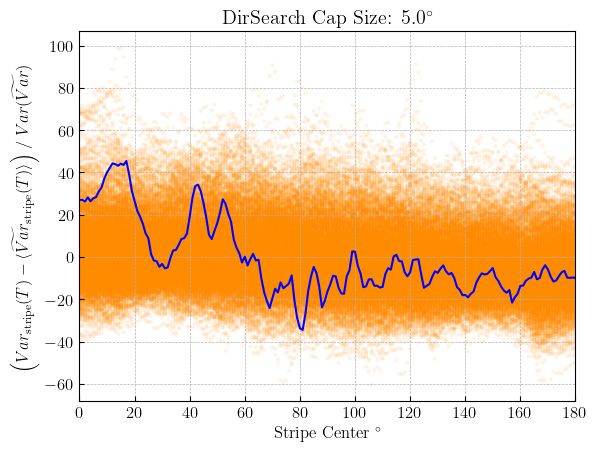

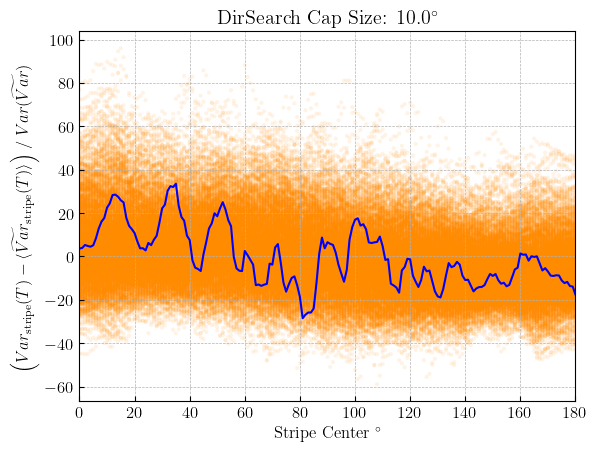

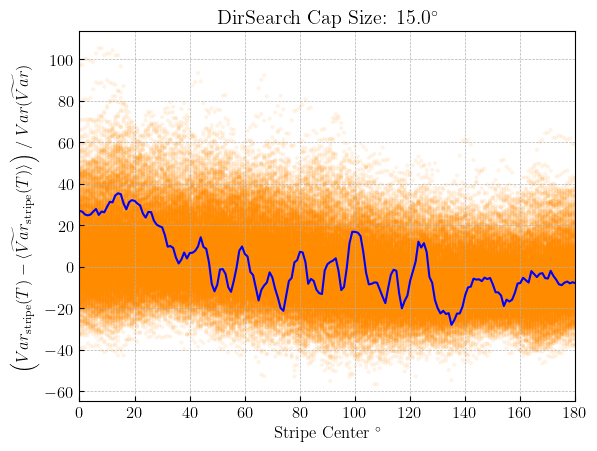

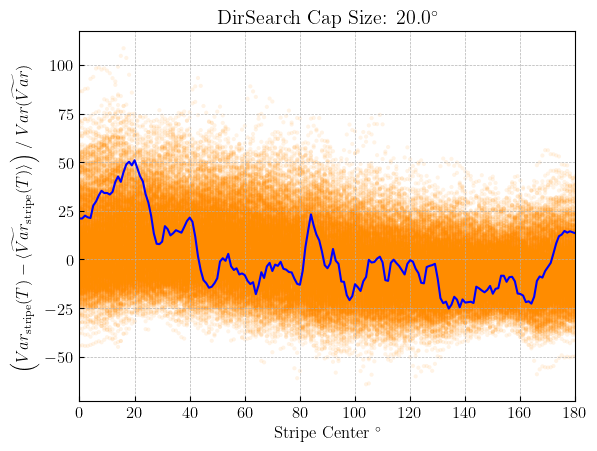

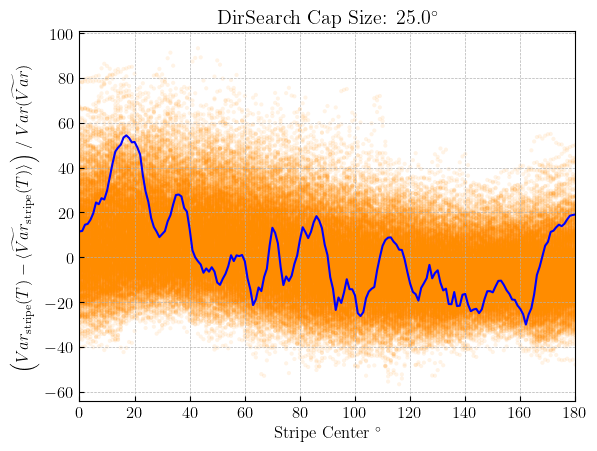

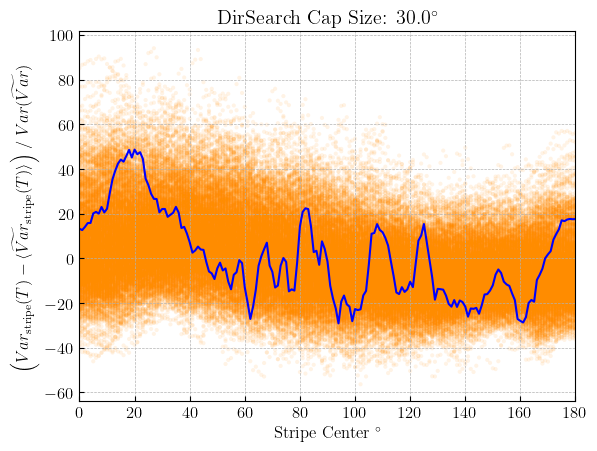

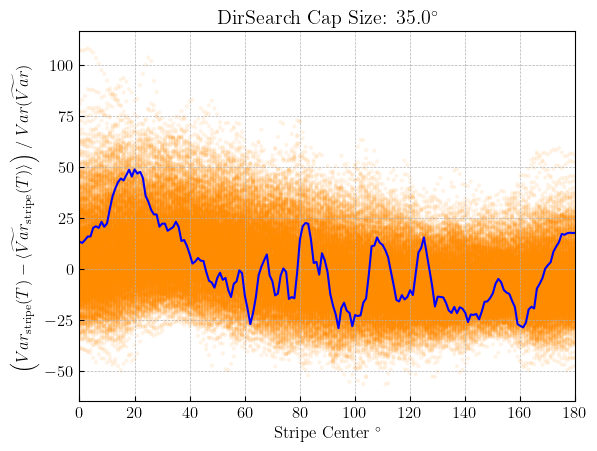

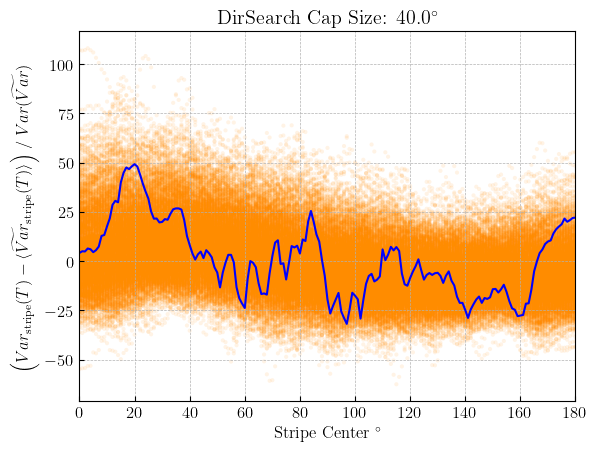

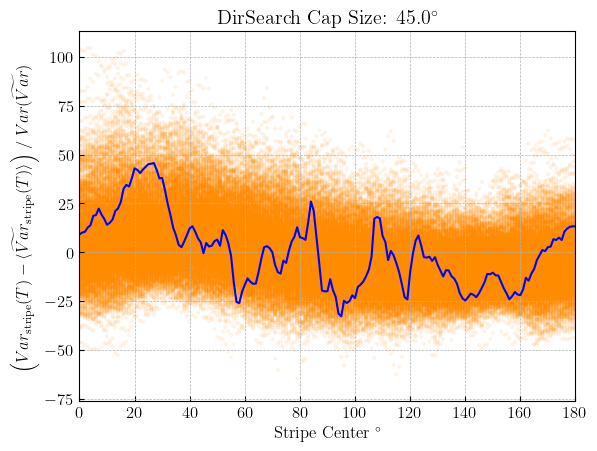

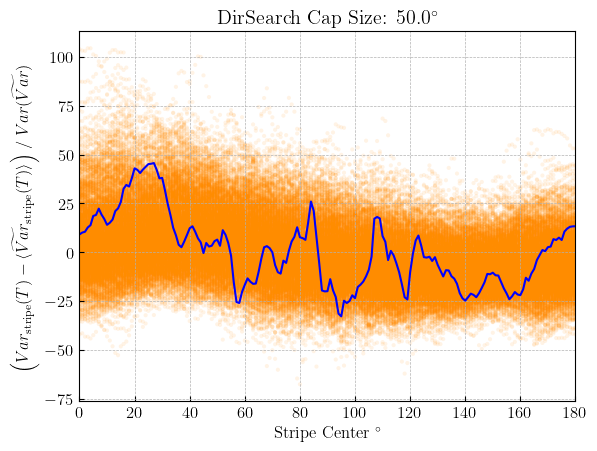

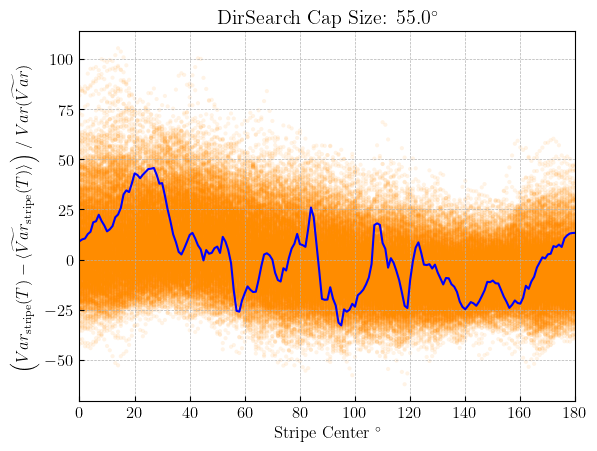

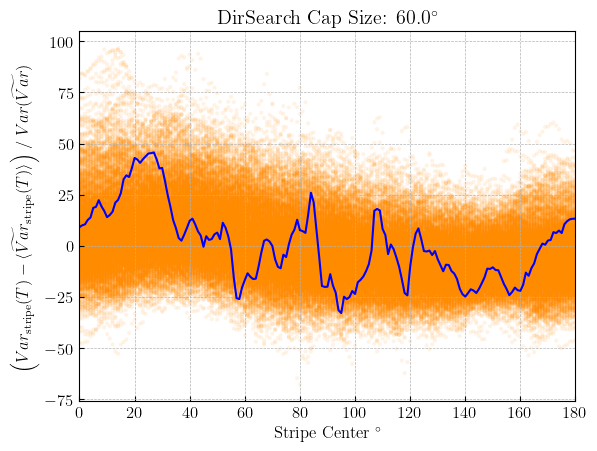

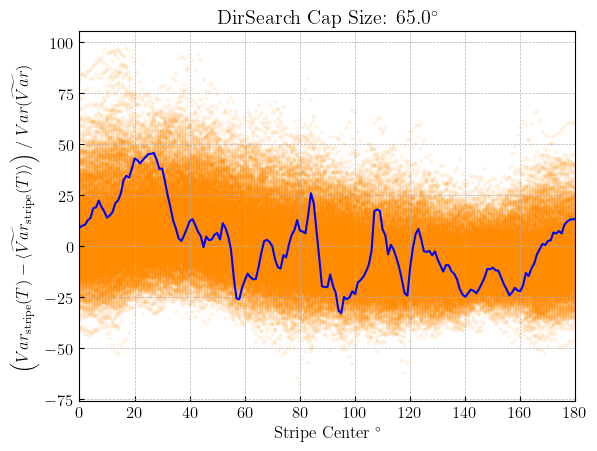

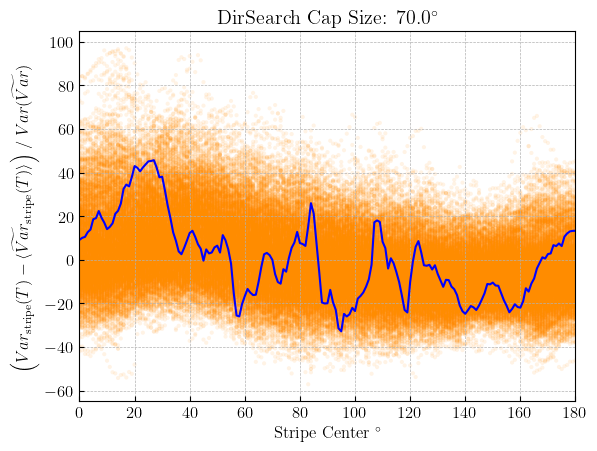

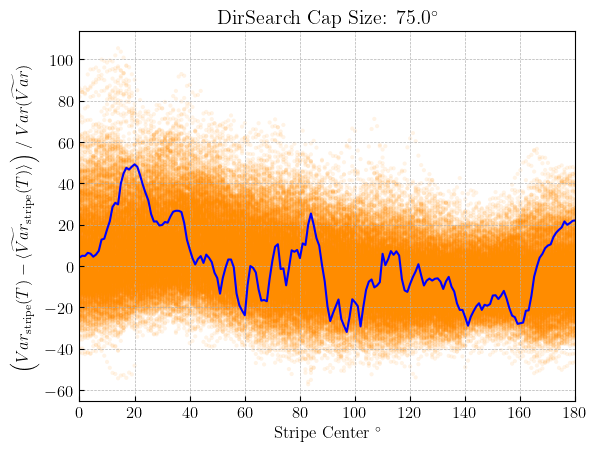

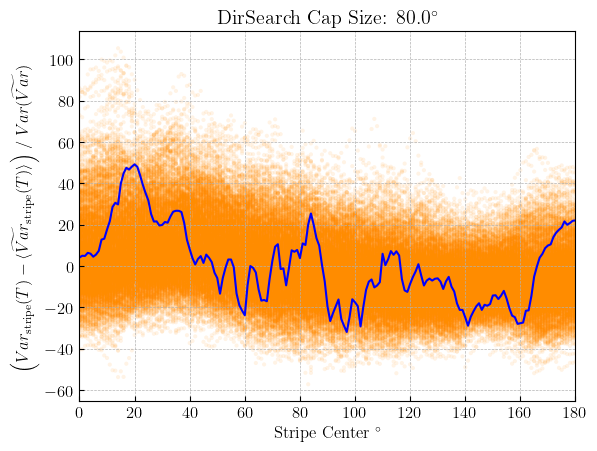

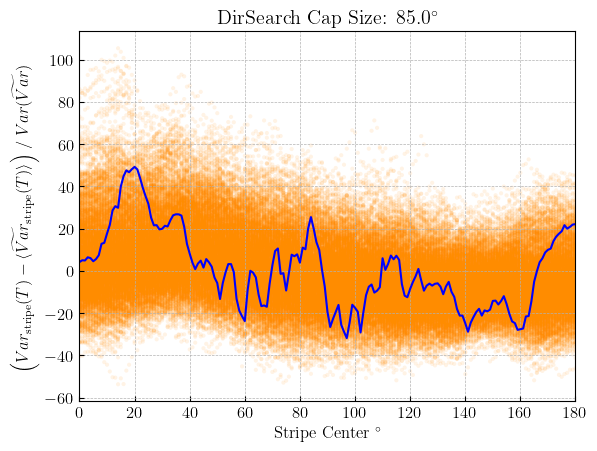

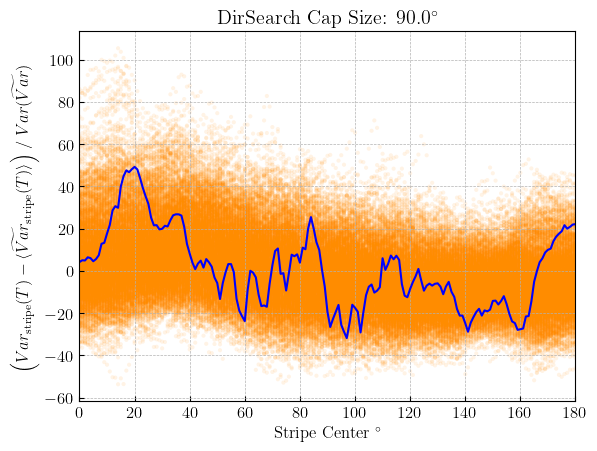

In [4]:
with plt.style.context('bmh'):
    for cap_size in dir_search_cap_sizes:
        fig, ax=plt.subplots()
        cmb_measure  = np.loadtxt(base_path + "{}_cmb_{:02}stripe_var_measure_{:02}deg_dir.txt".format(cleaning_pipeline, run_inputs.stripe_thickness, cap_size))
        sims_measure = np.loadtxt(base_path + "{}_sims_{:02}stripe_var_measure_{:02}deg_dir.txt".format(cleaning_pipeline, run_inputs.stripe_thickness, cap_size))
        for i in range(run_inputs.max_sim_num):
            ax.scatter(run_inputs.geom_range, sims_measure[i],
                       marker='.', edgecolors='none', linewidths=.5, c='darkorange', alpha=.1)
        ax.plot(run_inputs.geom_range, cmb_measure,
                color='b', linewidth=1.5)
        ax.set_xlabel(r"Stripe Center $^\circ$")
        ax.set_ylabel(r"$\bigg(Var_{\mathrm{stripe}}(T) - \big<\widetilde{Var}_{\mathrm{stripe}}(T)\big>\bigg) \; / \; Var(\widetilde{Var})$")
        ax.set_title(r"DirSearch Cap Size: ${cap_size}^\circ$".format(cap_size = cap_size))
        ax.set_xlim(xmin = 0, xmax = 180)
        ax.set_facecolor('white')
        # Axis colors
        for spine in ax.spines.keys(): ax.spines[spine].set_color('k')
        plt.show()

#### Finding $A_l$ 's

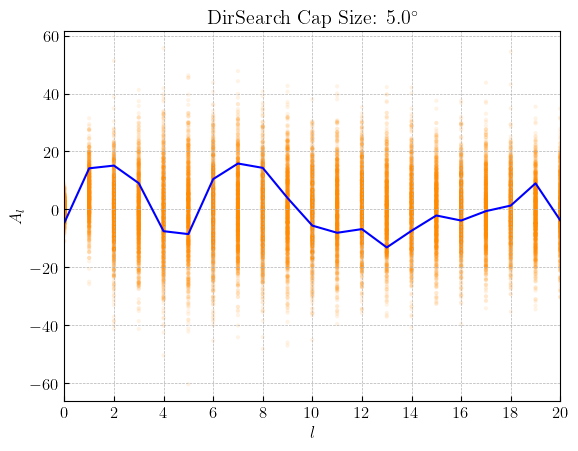

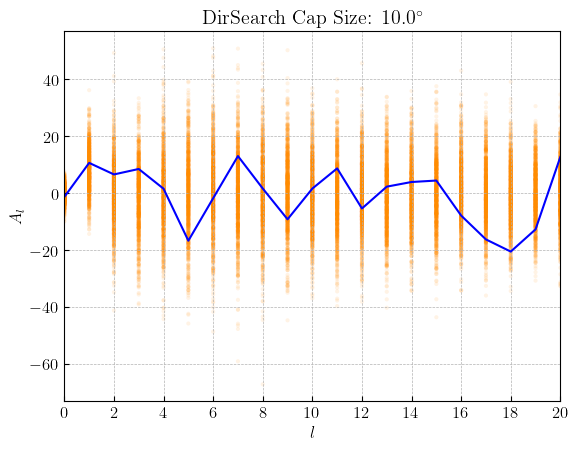

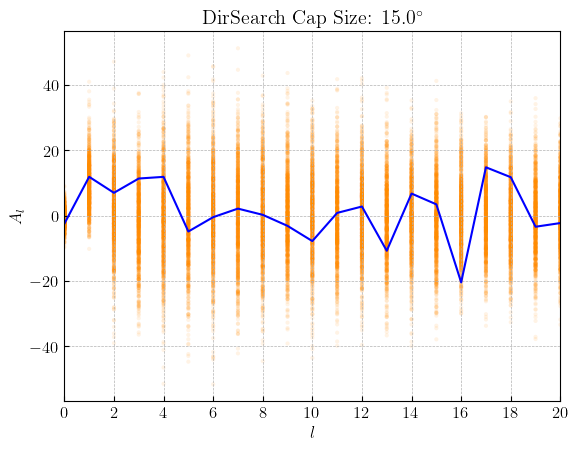

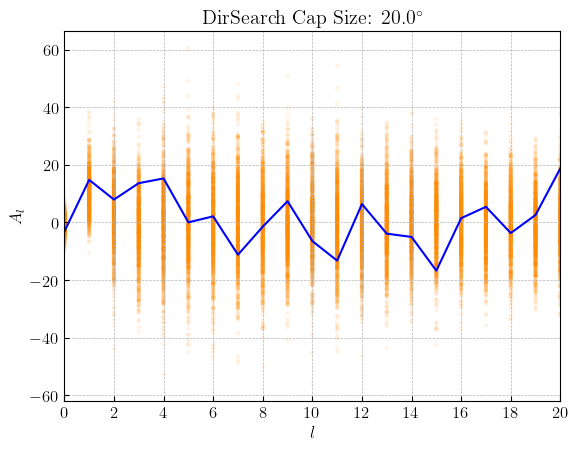

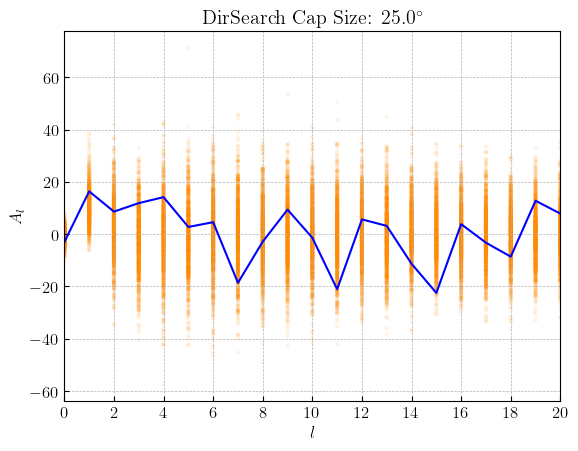

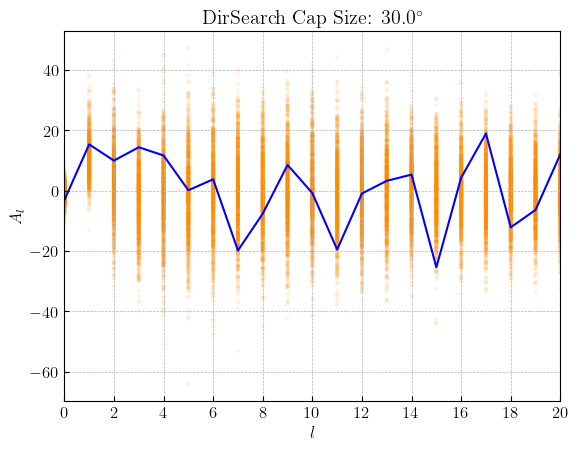

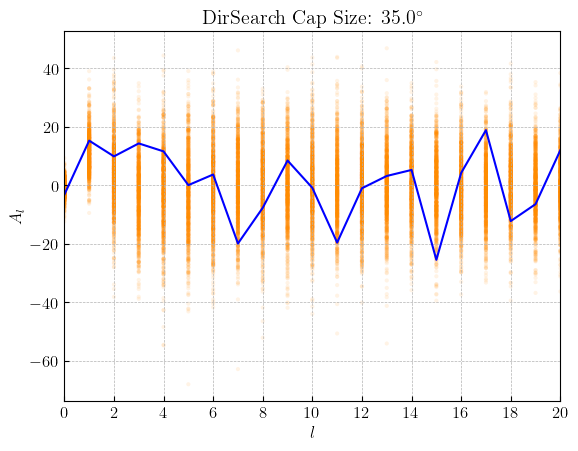

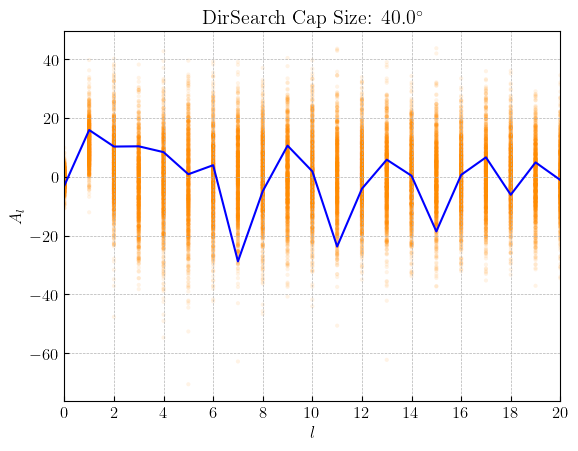

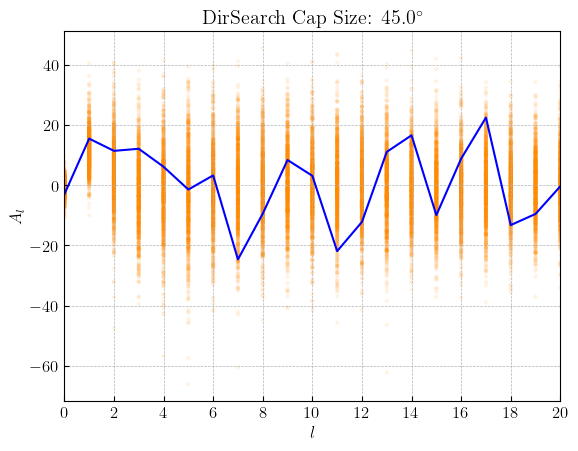

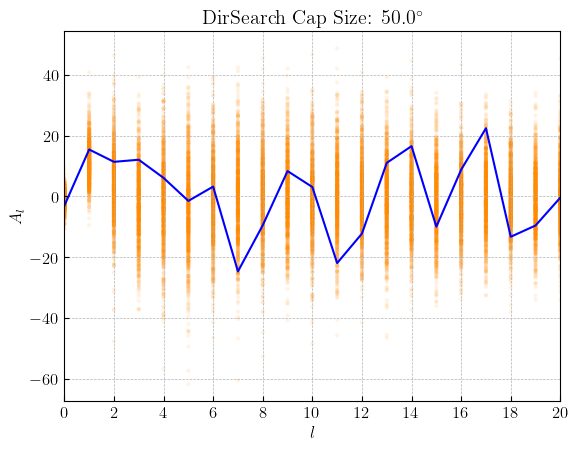

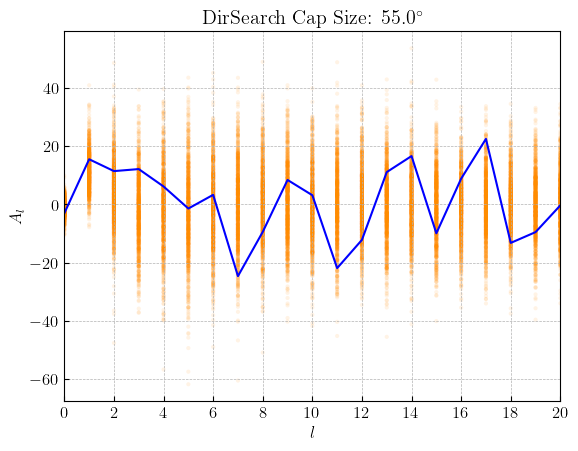

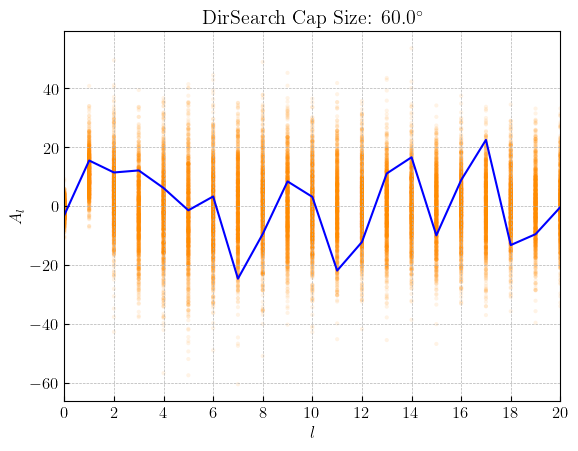

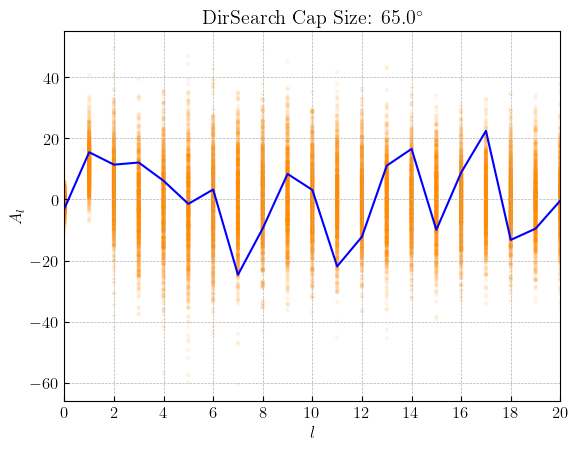

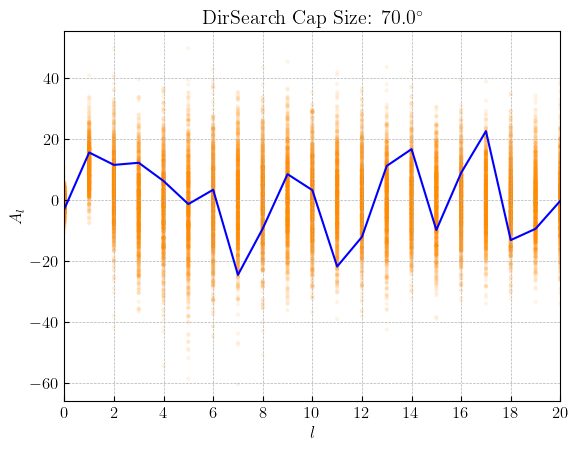

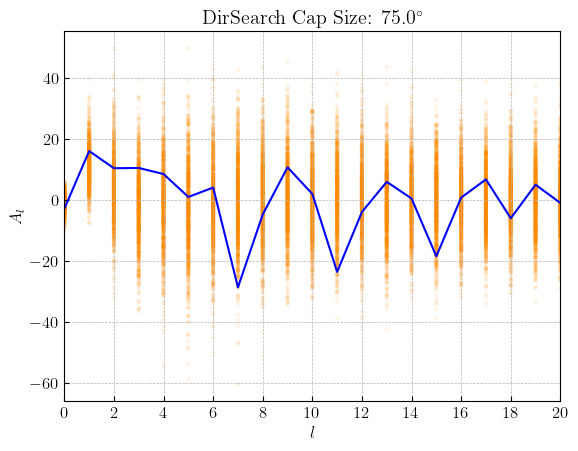

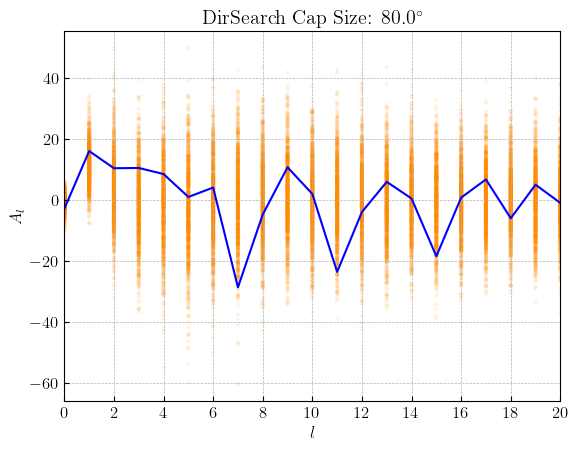

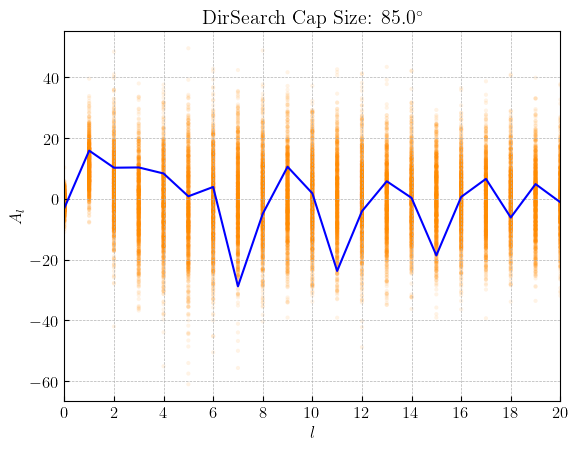

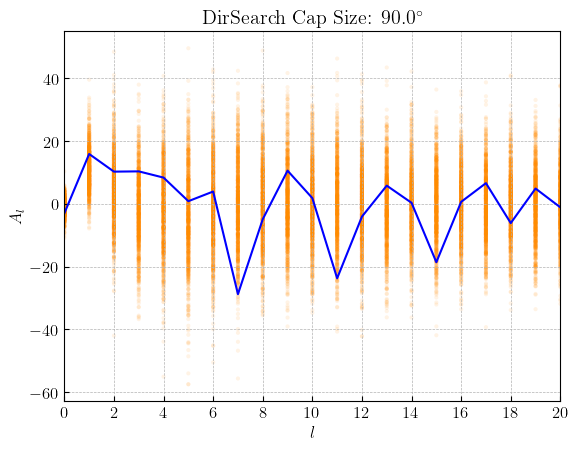

In [5]:
from matplotlib.ticker import MaxNLocator

theta_arr = np.pi / 180 * run_inputs.geom_range
max_l = 20
ell = np.arange(max_l + 1)

with plt.style.context('bmh'):
    for cap_size in dir_search_cap_sizes:
        fig, ax=plt.subplots()
        cmb_measure  = np.loadtxt(base_path + "{}_cmb_{:02}stripe_var_measure_{:02}deg_dir.txt".format(cleaning_pipeline, run_inputs.stripe_thickness, cap_size))
        sims_measure = np.loadtxt(base_path + "{}_sims_{:02}stripe_var_measure_{:02}deg_dir.txt".format(cleaning_pipeline, run_inputs.stripe_thickness, cap_size))
        cmb_al = cau.math_utils.get_all_legendre_coefs(theta_arr, cmb_measure, max_l)
        ax.plot(ell, cmb_al, color='b', linewidth=1.5)
        for i in range(run_inputs.max_sim_num):
            sim_al = cau.math_utils.get_all_legendre_coefs(theta_arr, sims_measure[i], max_l)
            ax.scatter(ell, sim_al,
                    marker='.', edgecolors='none', linewidths=1, c='darkorange', alpha=.1)
        ax.set_xlabel(r"$l$")
        ax.set_ylabel(r"$A_l$")
        ax.set_title(r"DirSearch Cap Size: ${cap_size}^\circ$".format(cap_size = cap_size))
        ax.set_xlim(xmin = 0, xmax = max_l)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_facecolor('white')
        # Axis colors
        for spine in ax.spines.keys(): ax.spines[spine].set_color('k')
        plt.show()

### Taking ***Stripes*** and computing ***Mean***

In [8]:
# Common Map Parameters
dummy_map = cau.dtypes.PixMap.create_dummy(run_inputs.dir_nside)
_theta = np.pi / 180 * run_inputs.geom_range

for cap_size in dir_search_cap_sizes[:1]:
    cmb_var     = np.loadtxt(base_path + "{}_cmb_var_{:02}cap.txt".format(cleaning_pipeline, cap_size))
    sims_vars   = np.loadtxt(base_path + "{}_sims_var_{:02}cap.txt".format(cleaning_pipeline, cap_size))
    # Set mask
    dummy_map.mask = np.isnan(cmb_var)
    # Find Mean Field
    mean_field = np.mean(sims_vars, axis = 0)
    var_var = np.var(sims_vars, axis = 0)
    
    _data = (cmb_var - mean_field) / var_var
    dummy_map.raw_data = _data

### Fitting $P_l$ on the variance map